In [549]:
%matplotlib inline
import matplotlib as mpl;
import matplotlib.pyplot as plt;
import pandas as pd
import zipfile

import numpy as np;
import gzip;
from io import StringIO; 

In [550]:
# import pandas as pd
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"

raw_data = pd.read_csv('11B5EC4D-4133-4289-B475-4E737182A406.features_labels.csv')
# print(raw_data.head())

In [551]:
count = 0 
for i in raw_data.columns: 
    
    print(count, i)
    count +=1

0 timestamp
1 raw_acc:magnitude_stats:mean
2 raw_acc:magnitude_stats:std
3 raw_acc:magnitude_stats:moment3
4 raw_acc:magnitude_stats:moment4
5 raw_acc:magnitude_stats:percentile25
6 raw_acc:magnitude_stats:percentile50
7 raw_acc:magnitude_stats:percentile75
8 raw_acc:magnitude_stats:value_entropy
9 raw_acc:magnitude_stats:time_entropy
10 raw_acc:magnitude_spectrum:log_energy_band0
11 raw_acc:magnitude_spectrum:log_energy_band1
12 raw_acc:magnitude_spectrum:log_energy_band2
13 raw_acc:magnitude_spectrum:log_energy_band3
14 raw_acc:magnitude_spectrum:log_energy_band4
15 raw_acc:magnitude_spectrum:spectral_entropy
16 raw_acc:magnitude_autocorrelation:period
17 raw_acc:magnitude_autocorrelation:normalized_ac
18 raw_acc:3d:mean_x
19 raw_acc:3d:mean_y
20 raw_acc:3d:mean_z
21 raw_acc:3d:std_x
22 raw_acc:3d:std_y
23 raw_acc:3d:std_z
24 raw_acc:3d:ro_xy
25 raw_acc:3d:ro_xz
26 raw_acc:3d:ro_yz
27 proc_gyro:magnitude_stats:mean
28 proc_gyro:magnitude_stats:std
29 proc_gyro:magnitude_stats:moment3

In [552]:
sensor_data = raw_data.iloc[:,1:226]
label_data = raw_data.iloc[:,226:]
print(label_data)

      label:LYING_DOWN  label:SITTING  label:FIX_walking  label:FIX_running  \
0                  0.0            1.0                0.0                NaN   
1                  0.0            1.0                0.0                NaN   
2                  0.0            1.0                0.0                NaN   
3                  0.0            1.0                0.0                NaN   
4                  0.0            1.0                0.0                NaN   
...                ...            ...                ...                ...   
8840               NaN            NaN                NaN                NaN   
8841               NaN            NaN                NaN                NaN   
8842               NaN            NaN                NaN                NaN   
8843               NaN            NaN                NaN                NaN   
8844               NaN            NaN                NaN                NaN   

      label:BICYCLING  label:SLEEPING  label:LAB_WO

In [5]:
def parse_header_of_csv(csv_str):
    # Isolate the headline columns:
    headline = csv_str[:csv_str.index(b'\n')];
    columns = headline.split(b',');

    # The first column should be timestamp:
    assert columns[0] == b'timestamp';
    # The last column should be label_source:
    assert columns[-1] == b'label_source';
    
    # Search for the column of the first label:
    for (ci,col) in enumerate(columns):
        if col.startswith(b'label:'):
            first_label_ind = ci;
            break;
        pass;

    # Feature columns come after timestamp and before the labels:
    feature_names = columns[1:first_label_ind];
    # Then come the labels, till the one-before-last column:
    label_names = columns[first_label_ind:-1];
    for (li,label) in enumerate(label_names):
        # In the CSV the label names appear with prefix 'label:', but we don't need it after reading the data:
        assert label.startswith(b'label:');
        label_names[li] = label.replace(b'label:',b'');
        pass;
    
    return (feature_names,label_names);

def parse_body_of_csv(csv_str,n_features):
    # Read the entire CSV body into a single numeric matrix:
    full_table = np.loadtxt(StringIO(csv_str.decode("utf-8")),delimiter=',',skiprows=1);
    
    # Timestamp is the primary key for the records (examples):
    timestamps = full_table[:,0].astype(int);
    
    # Read the sensor features:
    X = full_table[:,1:(n_features+1)];
    
    # Read the binary label values, and the 'missing label' indicators:
    trinary_labels_mat = full_table[:,(n_features+1):-1]; # This should have values of either 0., 1. or NaN
    M = np.isnan(trinary_labels_mat); # M is the missing label matrix
    Y = np.where(M,0,trinary_labels_mat) > 0.; # Y is the label matrix
    
    return (X,Y,M,timestamps);

'''
Read the data (precomputed sensor-features and labels) for a user.
This function assumes the user's data file is present.
'''
def read_user_data(uuid):
    user_data_file = '%s.features_labels.csv.gz' % uuid;

    # Read the entire csv file of the user:
    with gzip.open(user_data_file,'rb') as fid:
        csv_str = fid.read();
        pass;
    
    (feature_names,label_names) = parse_header_of_csv(csv_str);
    n_features = len(feature_names);
    (X,Y,M,timestamps) = parse_body_of_csv(csv_str,n_features);

    return (X,Y,M,timestamps,feature_names,label_names);

In [6]:
uuid = '1155FF54-63D3-4AB2-9863-8385D0BD0A13';
(X,Y,M,timestamps,feature_names,label_names) = read_user_data(uuid);
feature_names = [i.decode("utf-8") for i in feature_names]
label_names = [i.decode("utf-8") for i in label_names]

In [7]:
print(timestamps)

[1464129912 1464129950 1464130031 ... 1464887023 1464887322 1464887622]


In [8]:
print(label_names)
print(len(label_names))

['LYING_DOWN', 'SITTING', 'FIX_walking', 'FIX_running', 'BICYCLING', 'SLEEPING', 'LAB_WORK', 'IN_CLASS', 'IN_A_MEETING', 'LOC_main_workplace', 'OR_indoors', 'OR_outside', 'IN_A_CAR', 'ON_A_BUS', 'DRIVE_-_I_M_THE_DRIVER', 'DRIVE_-_I_M_A_PASSENGER', 'LOC_home', 'FIX_restaurant', 'PHONE_IN_POCKET', 'OR_exercise', 'COOKING', 'SHOPPING', 'STROLLING', 'DRINKING__ALCOHOL_', 'BATHING_-_SHOWER', 'CLEANING', 'DOING_LAUNDRY', 'WASHING_DISHES', 'WATCHING_TV', 'SURFING_THE_INTERNET', 'AT_A_PARTY', 'AT_A_BAR', 'LOC_beach', 'SINGING', 'TALKING', 'COMPUTER_WORK', 'EATING', 'TOILET', 'GROOMING', 'DRESSING', 'AT_THE_GYM', 'STAIRS_-_GOING_UP', 'STAIRS_-_GOING_DOWN', 'ELEVATOR', 'OR_standing', 'AT_SCHOOL', 'PHONE_IN_HAND', 'PHONE_IN_BAG', 'PHONE_ON_TABLE', 'WITH_CO-WORKERS', 'WITH_FRIENDS']
51


In [9]:
Y.shape 

(2685, 51)

In [10]:
X.shape

(2685, 225)

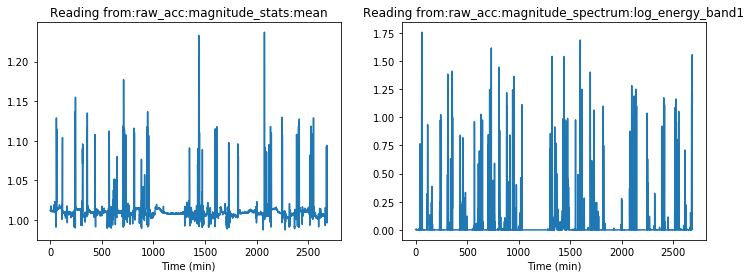

In [11]:
t = [i for i in range(len(X[:,0]))]
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(t,X[:,0])
plt.xlabel('Time (min)')
plt.title('Reading from:'+feature_names[0])
plt.subplot(122)
plt.plot(t,X[:,10])
plt.xlabel('Time (min)')
plt.title('Reading from:'+feature_names[10])
plt.show()

In [500]:
from os import listdir
from os.path import isfile, join
import gzip
import shutil

mypath = '/Users/ferlejarza/Desktop/ut_austin/4th_semester/EE380_data_mining/project/ExtraSensory.per_uuid_features_labels'
onlyfiles = [f for f in listdir(mypath)]
onlyfiles.remove('.DS_Store')
current_path = '/ExtraSensory.per_uuid_features_labels/'
final_files = [] 
for i in onlyfiles: 
    x = current_path+i[0:len(i)-4] 
    final_files.append(x)
    
print(final_files)

['/ExtraSensory.per_uuid_features_labels/81536B0A-8DBF-4D8A-AC24-9543E2E4C8E0.features_labels', '/ExtraSensory.per_uuid_features_labels/61359772-D8D8-480D-B623-7C636EAD0C81.features_labels', '/ExtraSensory.per_uuid_features_labels/40E170A7-607B-4578-AF04-F021C3B0384A.features_labels', '/ExtraSensory.per_uuid_features_labels/806289BC-AD52-4CC1-806C-0CDB14D65EB6.features_labels', '/ExtraSensory.per_uuid_features_labels/61976C24-1C50-4355-9C49-AAE44A7D09F6.features_labels', '/ExtraSensory.per_uuid_features_labels/D7D20E2E-FC78-405D-B346-DBD3FD8FC92B.features_labels', '/ExtraSensory.per_uuid_features_labels/7D9BB102-A612-4E2A-8E22-3159752F55D8.features_labels', '/ExtraSensory.per_uuid_features_labels/5119D0F8-FCA8-4184-A4EB-19421A40DE0D.features_labels', '/ExtraSensory.per_uuid_features_labels/9DC38D04-E82E-4F29-AB52-B476535226F2.features_labels', '/ExtraSensory.per_uuid_features_labels/A7599A50-24AE-46A6-8EA6-2576F1011D81.features_labels', '/ExtraSensory.per_uuid_features_labels/59EEFAE0-

In [501]:
# for idx in range(len(final_files)):
#     with gzip.open('.'+final_files[idx]+'.csv.gz', 'rb') as f_in:
#                 with open('.'+final_files[idx]+'.csv', 'wb') as f_out:
#                     shutil.copyfileobj(f_in, f_out)
            

In [502]:
import torch 
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim

AttributeError: 'Series' object has no attribute 'isnan'

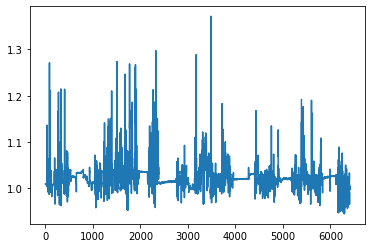

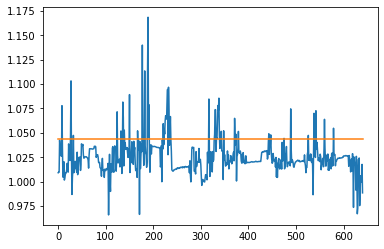

In [505]:

acc1 =  raw_d.iloc[:,1]
acc1.plot()
plt.show()
acc1.dropna(inplace = True)
acc2 = acc1.groupby(acc1.index // 10).mean()
acc2.plot()
plt.plot([0,640],[acc2.mean()+acc2.std(),acc2.mean()+acc2.std()])
plt.show()

    index  raw_acc:magnitude_stats:mean
0     189                      1.168493
1     177                      1.139940
2     188                      1.115884
3     182                      1.113473
4      27                      1.103229
..    ...                           ...
95    199                      1.036051
96    203                      1.036038
97     77                      1.035999
98    201                      1.035989
99    480                      1.035965

[100 rows x 2 columns]


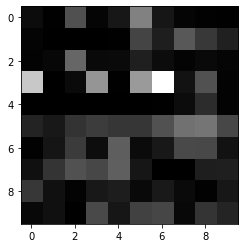

In [506]:

acc2_clean1 = acc2.nlargest(100).reset_index(drop=False)
print(acc2_clean1)
acc2_clean1 = acc2_clean1.sort_values('index', ascending = 1)
acc2_clean = acc2_clean1['raw_acc:magnitude_stats:mean'].to_numpy() 
plt.imshow(acc2_clean.reshape(10,10))

In [518]:
# min_dim = 1e10
# for idx in range(len(final_files)): 
#     raw_data = pd.read_csv('.'+final_files[idx]+'.csv')
#     if min_dim > raw_data.shape[0]: 
#         min_dim = raw_data.shape[0]

# print(min_dim)

# new_file_list = [] 

# for idx in range(len(final_files)): 
#     raw_data1 = pd.read_csv('.'+final_files[idx]+'.csv')
#     if min_dim < raw_data1.shape[0]: 
        
        
#         sensor_data = raw_data1.iloc[:,acc_gyr_ind]
#         sensor_data.dropna(inplace = True)
#         x = sensor_data.shape[0]
        
#         print(final_files[idx])
#         if x == 0:
#             continue 
#         sensor_data_sample = sensor_data.sample(min_dim,random_state=1)
#         new_file_list.append(final_files[idx])
#         print(x)

In [534]:
class SensoryDataset(Dataset): 
    
    def __init__(self, file_paths, transform):
        """provide directory with the user's data"""
        self.file_paths = file_paths
        self.transform = transform
        
    def __len__(self):
        return len(self.file_paths)
        
    def __getitem__(self, idx):
        
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        
        file_name = self.file_paths[idx]
        file_name = file_name[39:len(file_name)-16]
        
        rd = pd.read_csv('.'+self.file_paths[idx]+'.csv')
        sd = rd.iloc[:,[1]].dropna() # Keeping mean and std for acc and gyr featues 

    
        if 1600 < sensor_data.shape[0]: 

            sd_s = sd.sample(min_dim,random_state=1, replace = False)
        else: 
            sd_s = sd.sample(min_dim,random_state=1, replace = True)
        
#         sd_s1 = sd_s.nlargest(100,'raw_acc:magnitude_stats:mean').reset_index(drop=False)
#         sd_s2 = sd_s1.sort_values('index', ascending = 1)
#         sd_s2 = sd_s2['raw_acc:magnitude_stats:mean']
 
        sample =  sd_s
        
        if self.transform:
            # Transform to tensor
            sample = self.transform(sample.to_numpy())
        return sample 
    

# Construct 2 d image 
def reshape_img(tensor,w,h):
    return tensor.reshape([w,h])

# min-max normalization  
def min_max_norm(tensor, min_value, max_value):
    min_val = tensor.min()
    tensor = (tensor - min_val)
    max_val = tensor.max()
    tensor = tensor / max_val
    tensor = tensor * (max_val - min_val) + min_val
    return tensor 

img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda tensor:min_max_norm(tensor, 0, 1)),
    transforms.Lambda(lambda tensor:reshape_img(tensor,40,40))
])

In [535]:
data_set = SensoryDataset(file_paths=new_file_list,transform=img_transform)

In [536]:
a = np.array([[1,2],[1,2]])
np.mean(a)

1.5

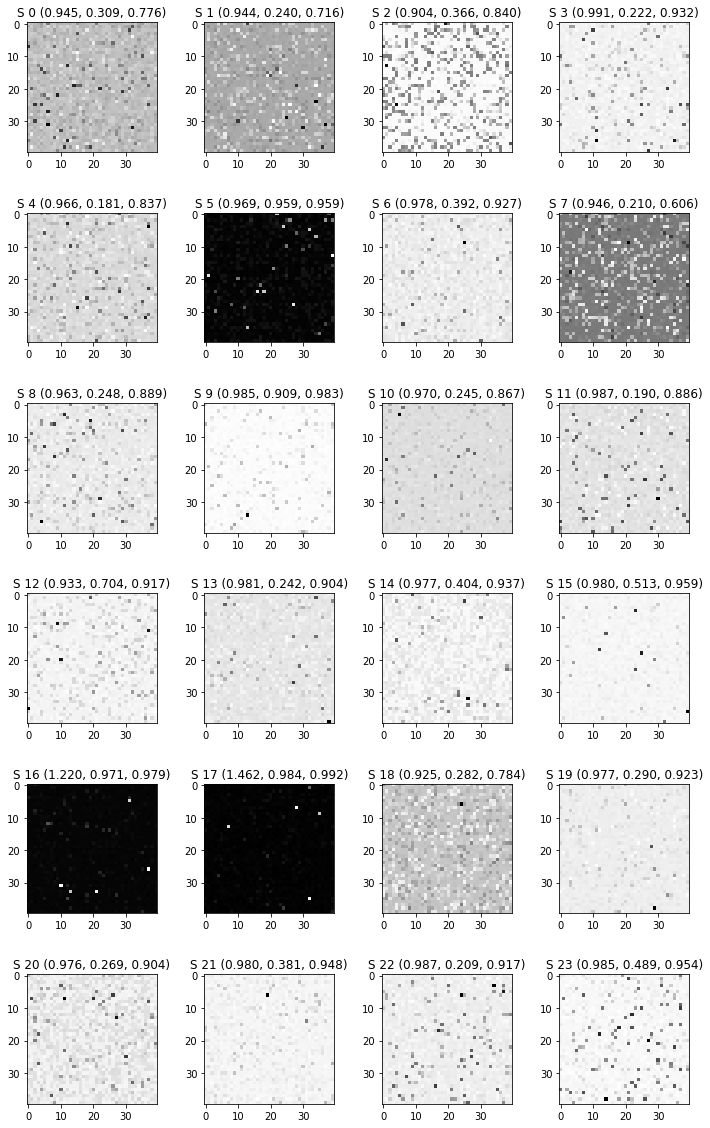

In [538]:
fig = plt.figure(figsize=(10, 16))
count = 0 
for i in range(24):
    ax = plt.subplot(6,4,count+1)
    im = data_set[count].numpy()
    
    plt.title('S %i (%1.3f, %1.3f, %1.3f)'%(i,np.amax(im),np.amin(im), np.mean(im)))
#     plt.xticks(np.arange(0,41,10))
#     plt.yticks(np.arange(0,41,10))
    plt.imshow(im)
    
    count +=1
fig.tight_layout(pad=1.0)

In [427]:
dataset_loader = torch.utils.data.DataLoader(data_set, batch_size=20, shuffle=True)


In [553]:
class AE(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(in_features=kwargs["input_shape"],out_features=256),
            nn.ReLU(True),
            nn.Linear(256, 64),
            nn.ReLU(True))
        self.decoder = nn.Sequential(
            nn.Linear(64, 256),
            nn.ReLU(True),
            nn.Linear(in_features= 256, out_features=kwargs["input_shape"]))
        
#         self.encoder_hidden_layer = nn.Linear(
#             in_features=kwargs["input_shape"], out_features=128
#         )
#         self.encoder_output_layer = nn.Linear(
#             in_features=128, out_features=128
#         )
#         self.decoder_hidden_layer = nn.Linear(
#             in_features=128, out_features=128
#         )
#         self.decoder_output_layer = nn.Linear(
#             in_features=128, out_features=kwargs["input_shape"]
#         )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [554]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [555]:
model = AE(input_shape=1600).to(device)

In [556]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [557]:
criterion = nn.MSELoss()

In [558]:
epochs = 20

for epoch in range(epochs):
    loss = 0
    count = 0 
    for batch_features in dataset_loader:
        batch_features = batch_features.view(-1, 1600).to(device)
        optimizer.zero_grad()
        outputs = model(batch_features.float())
        train_loss = criterion(outputs, batch_features.float())
        train_loss.backward()
        optimizer.step()
        loss += train_loss.item()
        
    # compute the epoch training loss
    loss = loss / len(dataset_loader)
    
    # display the epoch training loss
    print("epoch : {}/{}, loss = {:.6f}".format(epoch + 1, epochs, loss))

        

epoch : 1/20, loss = 0.753492
epoch : 2/20, loss = 0.414762
epoch : 3/20, loss = 0.144693
epoch : 4/20, loss = 0.053854
epoch : 5/20, loss = 0.036216
epoch : 6/20, loss = 0.030984
epoch : 7/20, loss = 0.025954
epoch : 8/20, loss = 0.020273
epoch : 9/20, loss = 0.016602
epoch : 10/20, loss = 0.013010
epoch : 11/20, loss = 0.011947
epoch : 12/20, loss = 0.011129
epoch : 13/20, loss = 0.010620
epoch : 14/20, loss = 0.010089
epoch : 15/20, loss = 0.009857
epoch : 16/20, loss = 0.009640
epoch : 17/20, loss = 0.011029
epoch : 18/20, loss = 0.010830
epoch : 19/20, loss = 0.009202
epoch : 20/20, loss = 0.009229


In [559]:
test_examples = None
reconstruction = None

count = 0 
with torch.no_grad():
    for batch_features in dataset_loader:
        test_examples = batch_features.view(-1, 1600)
        reconstruction = model(test_examples.float())
        break


In [560]:
print(test_examples.shape)
print(reconstruction.shape)

torch.Size([20, 1600])
torch.Size([20, 1600])


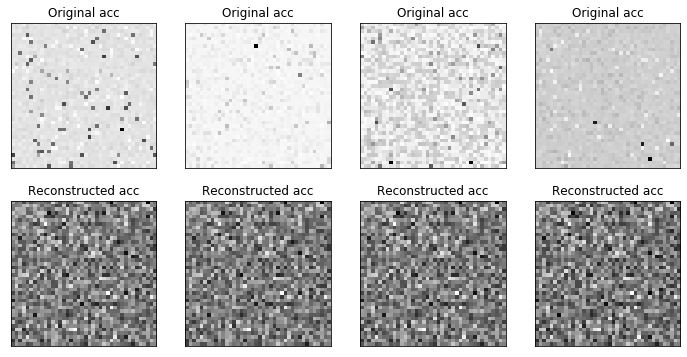

In [561]:
with torch.no_grad():
    number = 4
    plt.figure(figsize=(12, 6))
    for index in range(number):
        # display original
        ax = plt.subplot(2, number, index + 1)
        plt.imshow(test_examples[index].numpy().reshape(40, 40))
        plt.title('Original acc')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        # display reconstructed
        ax = plt.subplot(2, number, index + 1+ number)
        plt.imshow(reconstruction[index].numpy().reshape(40, 40))
        plt.title('Reconstructed acc')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        
    

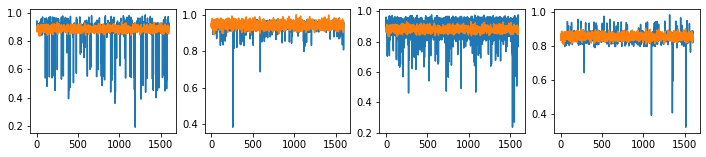

In [562]:
t = [i for i in range(1600)]
count = 0 
with torch.no_grad():
    number = 4
    plt.figure(figsize=(12, 5))
    for index in range(number):
        # display original
        ax = plt.subplot(2, 4, index + 1)
        sensor_read = test_examples[index].numpy().reshape(1600, 1)
        plt.plot(t,sensor_read)


        # display reconstructed
        sensor_read_rec = reconstruction[index].numpy().reshape(1600, 1)
        plt.plot(t,sensor_read_rec)
#         ax.get_xaxis().set_visible(False)
#         ax.get_yaxis().set_visible(False)
